In [2]:
import numpy as np
import tensorflow as tf
import keras
import argparse
import sys
import tempfile

# import keras
# from keras.datasets import mnist
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout, Flatten, Activation
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K
# from keras.models import model_from_json
# from keras.utils import plot_model

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

/Users/matthew/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


## Define the image preprocessing methods

In [ ]:
def preprocess(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     pd = 0.4 * r + 0.4 * g + 0.2 * b
#     pd = pd * (1. / 255) - 0.5
    pd=rgb * (1. / 255) #- 0.5
    return pd

def prepareDataArrays(iterator):
    X = np.empty((0, 14400))
    y = np.empty((0,1))
    X_buffer = np.empty((0, 14400))
    y_buffer = np.empty((0,1))
    
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])
        
        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = preprocess(image)
        image = image.reshape((14400))

        X_buffer = np.append(X_buffer, [image], axis=0)
        y_buffer = np.append(y_buffer, label)
        
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')
        if recordCounter % 1000 == 0:
            print("Merging")
            X = np.append(X, [X_buffer])
            y = np.append(y, [y_buffer])
            X_buffer = np.empty((0, 14400))
            y_buffer = np.empty((0,1))
    
    print("Done")        
    X = np.append(X, [X_buffer])
    y = np.append(y, y_buffer)
    
    X = X.reshape((recordCounter, 14400))
    y = y.reshape((recordCounter,))
    y = np.round(y / 6)
    y = y + 7
    return X, y

# Load the datasets for training 

## (from tfrecord to RAM)

In [ ]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")

print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)

## (from RAM to NPZ file)

In [ ]:
np.savez("arrays_01color.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val)

## (from NPZ file to RAM)

In [4]:
npRecall = np.load("arrays_01color.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]

## One-hot Encode

In [3]:
# (xt, yt), (xv, yv) = mnist.load_data()
X_train = X_train.astype('float32')
y_train = y_train.astype('uint8')
X_val = X_val.astype('float32')
y_val = y_val.astype('uint8')
y_train = keras.utils.to_categorical(y_train, 15)
y_val = keras.utils.to_categorical(y_val, 15)

## Define and compile the neural network

In [5]:
def deepnn(x):
    
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 14400])

  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([14400, 2048])
    b_fc1 = bias_variable([2048])
    h_fc1 = tf.nn.relu(tf.matmul(x_image, W_fc1) + b_fc1)
    
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([2048, 1024])
    b_fc2 = bias_variable([1024])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    
  with tf.name_scope('fc3'):
    W_fc3 = weight_variable([1024, 512])
    b_fc3 = bias_variable([512])
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)

  with tf.name_scope('fc4'):
    W_fc4 = weight_variable([512, 15])
    b_fc4 = bias_variable([15])
    y_conv = tf.matmul(h_fc3, W_fc4) + b_fc4
    
  return y_conv

def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


In [6]:
train_dataset = tf.data.TFRecordDataset('./train.tfrecords')
val_dataset = tf.data.TFRecordDataset('./val.tfrecords')

def _parse_function(example_proto):
    keys_to_features = {'X':tf.FixedLenFeature((), tf.float32),
                      'y': tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, keys_to_features)
    return parsed_features['X'], parsed_features['y']

train_dataset = train_dataset.map(_parse_function)
iterator = train_dataset.make_one_shot_iterator()
X, y = iterator.get_next()

In [9]:
sess=tf.InteractiveSession()
sess.run(X)

InvalidArgumentError: Feature: X (data type: float) is required but could not be found.
	 [[Node: ParseSingleExample/ParseSingleExample = ParseSingleExample[Tdense=[DT_FLOAT, DT_INT64], dense_keys=["X", "y"], dense_shapes=[[], []], num_sparse=0, sparse_keys=[], sparse_types=[]](arg0, ParseSingleExample/Const, ParseSingleExample/Reshape)]]
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[], []], output_types=[DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]

In [8]:
train_dataset = tf.data.TFRecordDataset('./train.tfrecords')
val_dataset = tf.data.TFRecordDataset('./val.tfrecords')


# Create the model
x = tf.placeholder(tf.float32, [None, 14400])

# Define loss and optimizer
y_ = tf.placeholder(tf.int64, [None])

# Build the graph for the deep net
y_conv = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

graph_location = './tfgraph/'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch = tf.train.batch(
            tensors,
            batch_size,
            num_threads=1,
            capacity=32,
            enqueue_many=True,
            shapes=None,
            dynamic_pad=False,
            allow_smaller_final_batch=False,
            shared_name=None,
            name=None
        )
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

Saving graph to: ./tfgraph/


NameError: name 'tensors' is not defined

In [10]:
saver = tf.train.Saver()
with K.get_session() as sess:
    K.set_learning_phase(0)
    saver.save(sess, './tfmodel/model')

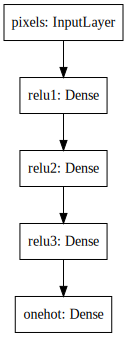

In [11]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))